In [234]:
import pandas as pd
import numpy as np
from inspect import getmro
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from operator import itemgetter
from itertools import islice
from sklearn.cluster import KMeans
from sklearn.utils.class_weight import compute_class_weight
import statsmodels.api as sm

import tensorflow as tsf

import warnings

warnings.filterwarnings('ignore')

print(f'Found TF-DF: {tsf.__version__}')

Found TF-DF: 2.13.0


In [14]:
test = pd.read_csv(r'C:\Users\aleksandrovva1\Desktop\titanic\test.csv')
train = pd.read_csv(r'C:\Users\aleksandrovva1\Desktop\titanic\train.csv')

In [15]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [16]:
test[test['Cabin'].isna()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
412,1304,3,"Henriksson, Miss. Jenny Lovisa",female,28.0,0,0,347086,7.7750,NaN,S
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [17]:
train[train['Age'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S
878,879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S


In [201]:
def preposition(df):
    df = df.copy()
    
    def nornalise_name(x):
        return " ".join([v.strip(",()[].\"'") for v in x.split(" ")])
    
    def ticket_number(x):
        return x.split(" ")[-1]
    
    def ticket_item(x):
        item = x.split(" ")
        if len(item) == 1:
            return "None"
        else:
            return "_".join(item[0:-1])
        
    df['Name'] = df['Name'].apply(nornalise_name)
    df['Ticket_number'] = df['Ticket'].apply(ticket_number)
    df['Ticket_item'] = df['Ticket'].apply(ticket_item)
    
    return df

preproc_train = preposition(train)
preproc_test = preposition(test)

In [202]:
def Preprocessing(train_data):
    #Deal with Missing values, for Embarked, fill with the value that occurs the most
    #train_data['Cabin'].fillna("N0",inplace=True)
    train_data['Age'].fillna(train_data['Age'].mean(),inplace=True)
    train_data['Fare'].fillna(train_data['Fare'].mean(),inplace=True)
    train_data['Embarked'].fillna(train_data['Embarked'].mode()[0],inplace=True)
    train_data['Embarked'] = train_data['Embarked'].astype('str')

    #Maybe Cabin have information as which part of the boat the individual was located,and relate to the survival rate, Due to the complexity of how this is logged,we will use the section letter
    #train_data['Cabin_Section']=train_data['Cabin'].map(lambda x:x[0])
    #The Cabin info in hard to be utilized, meanwhile, train & test data have diff cabin numbers, and there's 75% of missing values in cabin, we will just drop this column
    
    col_for_lble = ['Sex',
                   'Embarked']
    original_dict = {}
    encoder = LabelEncoder()
    for i in col_for_lble:
        train_data[i] = encoder.fit_transform(train_data[i])
        original_dict[i] = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
    

    #Drop columns that are not informative
    train_data = train_data.drop(['Cabin','Name','Ticket','Ticket_number','Ticket_item'],axis=1)
    columns = ['Sex','Embarked','Pclass', 'Parch'] #+ ['Cabin','Name','Ticket','Ticket_number','Ticket_item']
    get_dumm = pd.get_dummies(train_data[columns], columns=columns)
    train_data = pd.concat([train_data.drop(columns+['PassengerId'], axis=1), get_dumm],axis=1)
    train_data['Age'] = round(train_data['Age'],2)
    train_data['Fare'] = round(train_data['Fare'],3)
    #Convert Dummy variables 
    return train_data, original_dict

def get_class_name(cls):
    names = [base.__name__ for base in getmro(cls)]
    return names[0]

In [203]:
preproc_train, dict_for_train = Preprocessing(preproc_train)
preproc_test, dict_for_test= Preprocessing(preproc_test)

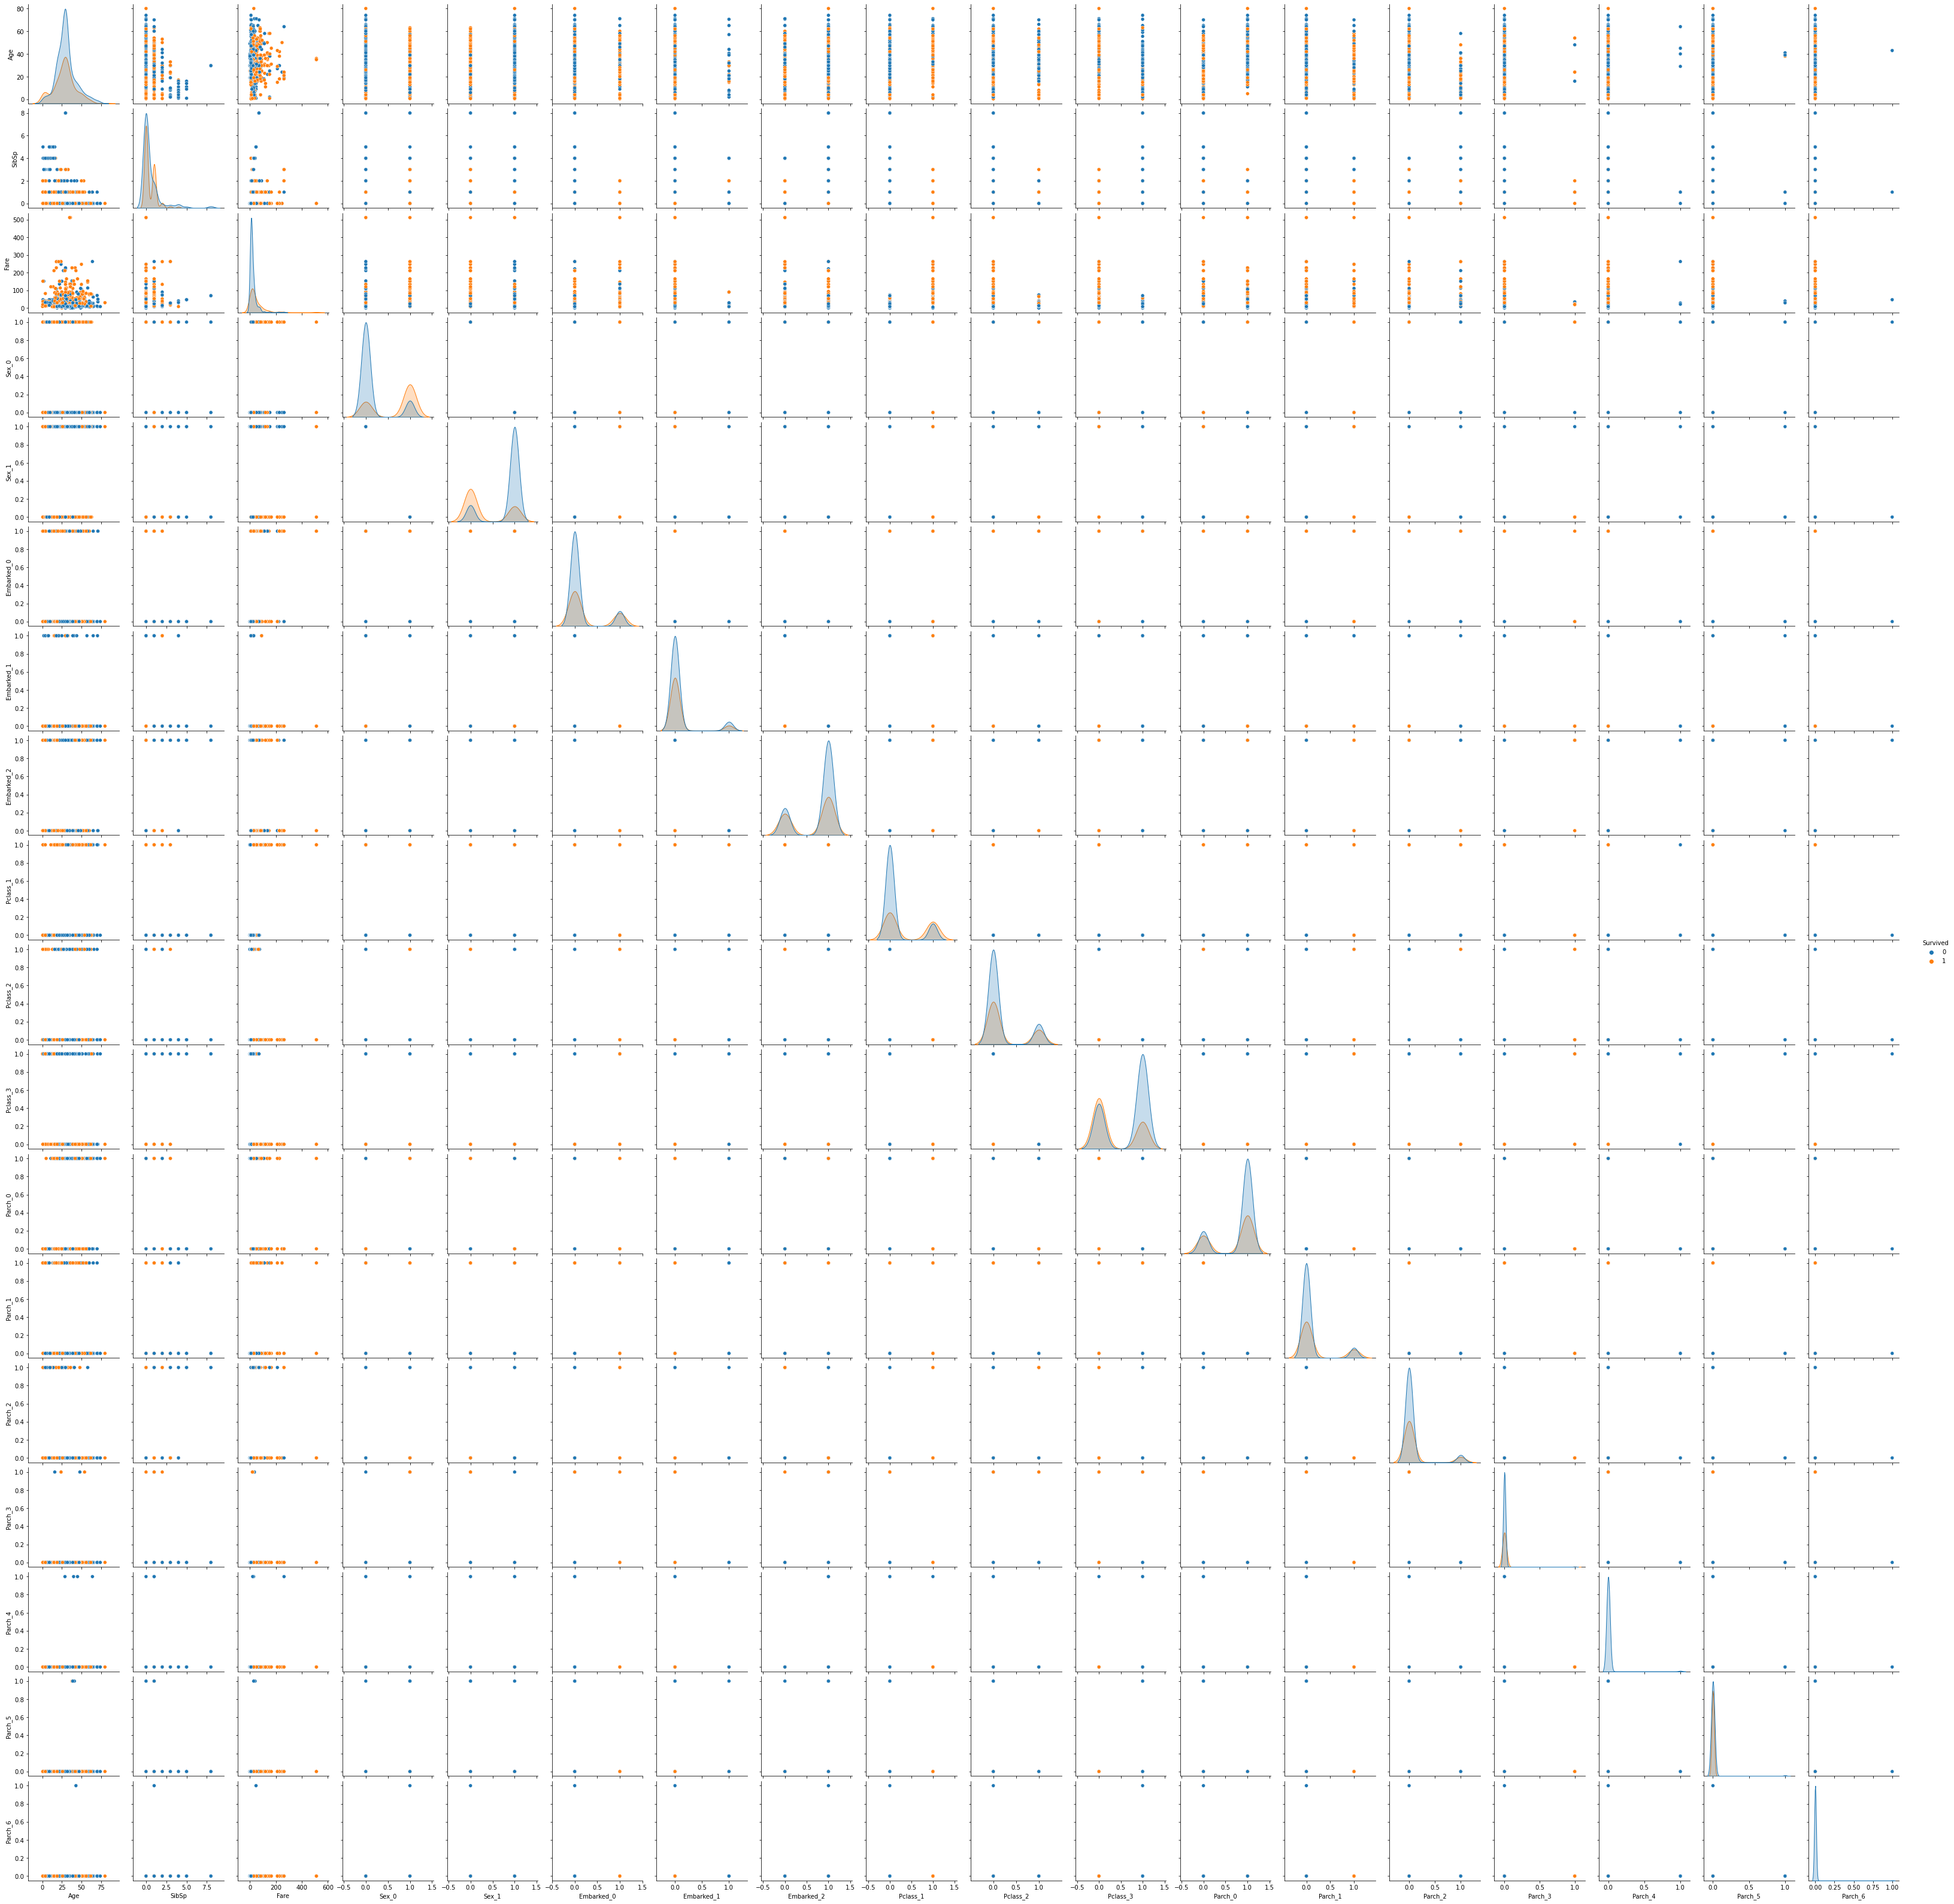

{'Sex': {'female': 0, 'male': 1}, 'Embarked': {'C': 0, 'Q': 1, 'S': 2}}


In [150]:
sns.pairplot(data=preproc_train, hue='Survived')
plt.show()
print(dict_for_train)

In [204]:
columns_for_train_model = [i for i in preproc_train.columns if i not in ['Survived']]
target = 'Survived'       

In [205]:
train_x, test_x, train_y, test_y = train_test_split(preproc_train[columns_for_train_model],
                                                    preproc_train[target], 
                                                    random_state=42, 
                                                    train_size=0.7,
                                                    shuffle=True,
                                                    stratify=preproc_train[target])

In [178]:
train_x

,Age,SibSp,Parch,Fare,Sex_0,Sex_1,Embarked_0,Embarked_1,Embarked_2,Pclass_1,Pclass_2,Pclass_3
748,19.0,1,0,53.100,0,1,0,0,1,1,0,0
45,29.7,0,0,8.050,0,1,0,0,1,0,0,1
28,29.7,0,0,7.879,1,0,0,1,0,0,0,1
633,29.7,0,0,0.000,0,1,0,0,1,1,0,0
403,28.0,1,0,15.850,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
476,34.0,1,0,21.000,0,1,0,0,1,0,1,0
190,32.0,0,0,13.000,1,0,0,0,1,0,1,0
736,48.0,1,3,34.375,1,0,0,0,1,0,0,1
462,47.0,0,0,38.500,0,1,0,0,1,1,0,0


In [179]:
class_weights

{0: 0.8111979166666666, 1: 1.3033472803347281}

In [121]:
len(train_y[train_y==0])/len(train_y), len(train_y[train_y==1])/len(train_y)

(0.6163723916532905, 0.38362760834670945)

In [122]:
len(test_y[test_y==0])/len(test_y), len(test_y[test_y==1])/len(test_y)

(0.6156716417910447, 0.3843283582089552)

In [190]:
models = [RandomForestClassifier, LogisticRegression, DecisionTreeClassifier, CatBoostClassifier]
scores = {}

In [191]:
for j in range(1,15,1):
    for i in models:
        if i == CatBoostClassifier:
            model = i(verbose=0).fit(train_x, train_y)
        else:
            model = i().fit(train_x, train_y)
        pred = model.predict(test_x)
        scores.setdefault(get_class_name(i), []).append(roc_auc_score(pred, test_y))

In [182]:
pd.DataFrame(scores)

,RandomForestClassifier,LogisticRegression,DecisionTreeClassifier,CatBoostClassifier
0,0.808034,0.789352,0.747732,0.790634
1,0.792668,0.789352,0.740098,0.790634
2,0.788569,0.789352,0.743740,0.790634
3,0.814992,0.789352,0.757358,0.790634
4,0.794120,0.789352,0.735954,0.790634
5,0.804372,0.789352,0.748585,0.790634
6,0.799714,0.789352,0.748176,0.790634
7,0.806759,0.789352,0.747893,0.790634
8,0.799195,0.789352,0.752422,0.790634
9,0.785706,0.789352,0.753582,0.790634


In [192]:
pd.DataFrame(scores)

,RandomForestClassifier,LogisticRegression,DecisionTreeClassifier,CatBoostClassifier
0,0.784257,0.781199,0.731843,0.795757
1,0.797505,0.781199,0.752422,0.795757
2,0.780682,0.781199,0.735826,0.795757
3,0.803236,0.781199,0.743810,0.795757
4,0.811512,0.781199,0.740098,0.795757
5,0.803236,0.781199,0.735826,0.795757
6,0.799714,0.781199,0.739788,0.795757
7,0.799714,0.781199,0.748585,0.795757
8,0.796192,0.781199,0.748585,0.795757
9,0.784257,0.781199,0.735833,0.795757


In [183]:
for i in pd.DataFrame(scores).columns:
    print('****'*20)
    print(f'расхождение по обучению по колонке {i} : {np.std(pd.DataFrame(scores)[i])}')
    print(f'среднее по обучению по колонке {i} : {np.mean(pd.DataFrame(scores)[i])}')
    print('****'*20)

********************************************************************************
расхождение по обучению по колонке RandomForestClassifier : 0.008470844098021183
среднее по обучению по колонке RandomForestClassifier : 0.8013321728791497
********************************************************************************
********************************************************************************
расхождение по обучению по колонке LogisticRegression : 0.0
среднее по обучению по колонке LogisticRegression : 0.7893519926985093
********************************************************************************
********************************************************************************
расхождение по обучению по колонке DecisionTreeClassifier : 0.006033647416834131
среднее по обучению по колонке DecisionTreeClassifier : 0.7465752465620792
********************************************************************************
***********************************************************************

In [193]:
for i in pd.DataFrame(scores).columns:
    print('****'*20)
    print(f'расхождение по обучению по колонке {i} : {np.std(pd.DataFrame(scores)[i])}')
    print(f'среднее по обучению по колонке {i} : {np.mean(pd.DataFrame(scores)[i])}')
    print('****'*20)

********************************************************************************
расхождение по обучению по колонке RandomForestClassifier : 0.009975977062735047
среднее по обучению по колонке RandomForestClassifier : 0.7944635167403885
********************************************************************************
********************************************************************************
расхождение по обучению по колонке LogisticRegression : 0.0
среднее по обучению по колонке LogisticRegression : 0.7811986613933678
********************************************************************************
********************************************************************************
расхождение по обучению по колонке DecisionTreeClassifier : 0.006028450443388105
среднее по обучению по колонке DecisionTreeClassifier : 0.7423420016846486
********************************************************************************
***********************************************************************

In [68]:
params = {
    'l2_leaf_reg': np.arange(0,1,0.1),
    'border_count': np.arange(3,20,1),
    'leaf_estimation_method': ['Gradient', 'Newton', 'Exact', 'Simple'],
    #'model_size_reg_factor': numpy.arange(1,10,1),
    #'scale_pos_weight': numpy.arange(0,1,0.1),
    'use_best_model': [True, False]
}

classes = np.unique(train_y)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_y)
class_weights = dict(zip(classes, weights))

model = CatBoostClassifier(class_weights=class_weights, iterations=550, depth=4, verbose=False, learning_rate=0.02)

rs = RandomizedSearchCV(model, params, cv=3, random_state=42, scoring='roc_auc', n_iter=300).fit(train_x, train_y)
print(rs.best_params_)
print(rs.best_score_)

{'use_best_model': False, 'leaf_estimation_method': 'Newton', 'l2_leaf_reg': 0.6000000000000001, 'border_count': 12}
0.8687825520833333


In [213]:
estima = np.arange(50,2000,50)
depth = np.arange(2,16,1)
scored = {}

for i in estima:
    for j in depth:
        model = RandomForestClassifier(n_estimators=i, max_depth=j).fit(train_x, train_y)
        preds = model.predict(test_x)
        scored.setdefault(f'estimator{i}_depth{j}', []).append(roc_auc_score(preds, test_y))

In [219]:
sorted_dict = sorted(scored.items(), key=itemgetter(1), reverse = True)
top10_values = list(islice(sorted_dict, 10))
for i in top10_values:
    print(i)

('estimator1200_depth5', [0.8230053191489362])
('estimator100_depth10', [0.822979797979798])
('estimator300_depth9', [0.8216007714561234])
('estimator1450_depth4', [0.8216007714561234])
('estimator500_depth5', [0.820548124836087])
('estimator150_depth11', [0.8196481869562456])
('estimator700_depth9', [0.8196481869562456])
('estimator200_depth4', [0.8183229813664596])
('estimator600_depth4', [0.8183229813664596])
('estimator1250_depth4', [0.8183229813664596])


In [206]:
classes = np.unique(train_y)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_y)
class_weights = dict(zip(classes, weights))
model = CatBoostClassifier(iterations=550,
                           class_weights=class_weights,
                               depth=4, 
                               verbose=False, 
                               learning_rate=0.02,
                               use_best_model= False, 
                               leaf_estimation_method= 'Newton', 
                               l2_leaf_reg= 0.6000000000000001, 
                               border_count= 12,
                              ).fit(train_x, train_y)
pred = model.predict_proba(test_x)[:,1]
roc_auc_score(test_y, pred)

0.8636657840541335

In [126]:
weights[::-1]

array([1.30334728, 0.81119792])

In [231]:
roc_auc_score(test_y, pred)

0.8610473668726096

In [27]:
iterations_n = np.arange(50,2000,50)
depth = np.arange(2,7,1)
scored = {}

for i in iterations_n:
    for j in depth:
        model = CatBoostClassifier(iterations=i, depth=j, verbose=False).fit(train_x, train_y)
        preds = model.predict(test_x)
        scored.setdefault(f'estimator{i}_depth{j}', []).append(roc_auc_score(preds, test_y))
sorted_dict = sorted(scored.items(), key=itemgetter(1), reverse = True)
top10_values = list(islice(sorted_dict, 20))
for i in top10_values:
    print(i)

('estimator450_depth2', [0.8263134768689976])
('estimator650_depth2', [0.8263134768689976])
('estimator400_depth3', [0.8261701987192183])
('estimator500_depth3', [0.8261701987192183])
('estimator600_depth3', [0.8261701987192183])
('estimator850_depth3', [0.8261701987192183])
('estimator900_depth3', [0.8261701987192183])
('estimator950_depth3', [0.8261701987192183])
('estimator950_depth4', [0.8261701987192183])
('estimator1050_depth3', [0.8261701987192183])
('estimator1200_depth3', [0.8261701987192183])
('estimator1250_depth3', [0.8261701987192183])
('estimator1300_depth3', [0.8261701987192183])
('estimator1400_depth3', [0.8261701987192183])
('estimator1450_depth3', [0.8261701987192183])
('estimator1500_depth3', [0.8261701987192183])
('estimator1650_depth3', [0.8261701987192183])
('estimator1700_depth3', [0.8261701987192183])
('estimator1800_depth3', [0.8261701987192183])
('estimator1850_depth4', [0.8261701987192183])


In [52]:
depth = np.arange(0.01,0.5,0.01)
score = []
for i in depth:
    model = CatBoostClassifier(iterations=550, depth=4, verbose=False, learning_rate=0.02).fit(train_x, train_y)
    preds = model.predict_proba(test_x)[:,1]
    score.append(roc_auc_score(test_y, preds))

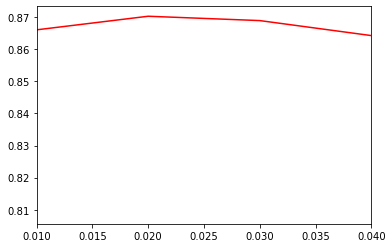

In [55]:
plt.plot(depth,score, c='red')
plt.xlim(0.01,0.04)
plt.show()

In [75]:
model = CatBoostClassifier(iterations=550, depth=4, verbose=False).fit(train_x, train_y)
preds = model.predict_proba(test_x)[:,1]
roc_auc_score(test_y, preds)

0.871344513092086

<AxesSubplot:>

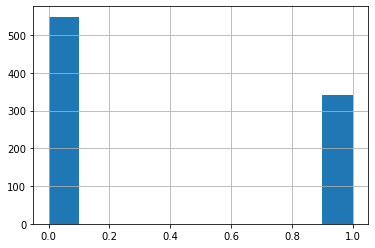

In [77]:
train['Survived'].hist()

In [11]:
from sklearn import tree
from sklearn.tree import export_graphviz
from graphviz import Source

clf=tree.DecisionTreeClassifier(max_depth=5)
clf=clf.fit(train_x,train_y)
print(f1_score(test_y,clf.predict(test_x)))
print(roc_auc_score(test_y, clf.predict_proba(test_x)[:, 1]))

0.6888888888888889
0.8496616651956458


In [12]:
export_graphviz(clf, out_file="tree_conversion.dot", feature_names=train_x.columns, proportion=True, rotate=True)
with open("tree_conversion.dot") as f:
    dot_graph = f.read()
  
s = Source.from_file("tree_conversion.dot")
s

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [118]:
classes = np.unique(train_y)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_y)
class_weights = dict(zip(classes, weights))
model = CatBoostClassifier(iterations=550,
                           class_weights=class_weights,
                               depth=4, 
                               verbose=False, 
                               learning_rate=0.02,
                               use_best_model= False, 
                               leaf_estimation_method= 'Newton', 
                               l2_leaf_reg= 0.6000000000000001, 
                               border_count= 12,
                              ).fit(train_x, train_y)
pred = model.predict_proba(test_x)[:,1]
roc_auc_score(test_y, pred)

0.8636657840541335

In [119]:
class_weights

{0: 0.8111979166666666, 1: 1.3033472803347281}

In [129]:
preproc_train

,Survived,Age,SibSp,Fare,Sex_0,Sex_1,Embarked_0,Embarked_1,Embarked_2,Pclass_1,Pclass_2,Pclass_3,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6
0,0,22.0,1,7.250,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0
1,1,38.0,1,71.283,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0
2,1,26.0,0,7.925,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0
3,1,35.0,1,53.100,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0
4,0,35.0,0,8.050,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,27.0,0,13.000,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0
887,1,19.0,0,30.000,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0
888,0,29.7,1,23.450,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0
889,1,26.0,0,30.000,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0


<AxesSubplot:>

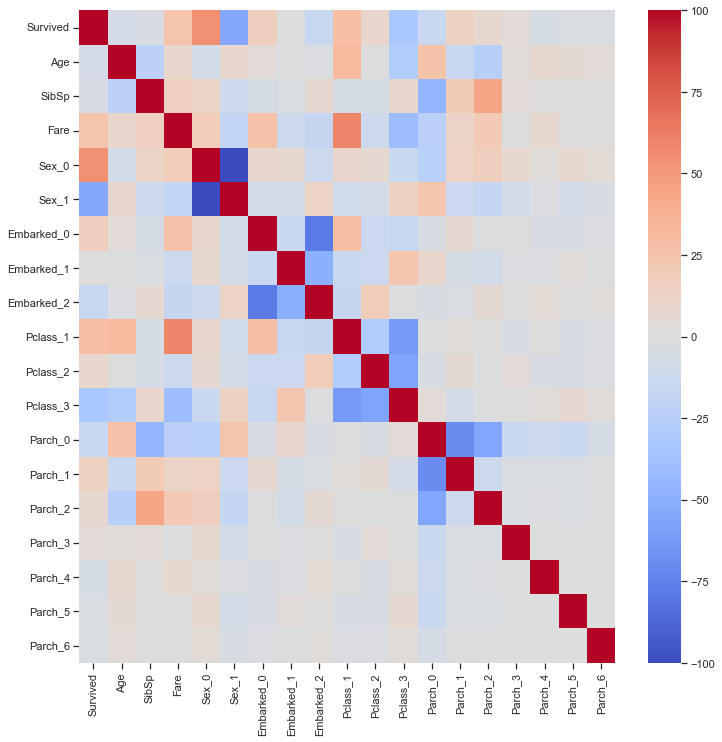

In [207]:
sns.set(style="ticks", rc={"figure.figsize": (12, 12)})
sns.heatmap(preproc_train.corr()*100, cmap="coolwarm")

In [214]:
knn = SelectKBest(k=9).fit(train_x, train_y)

In [215]:
for feature in knn.get_support(indices=True):
    print(train_x.columns[feature])

Fare
Sex_0
Sex_1
Embarked_0
Embarked_2
Pclass_1
Pclass_3
Parch_0
Parch_2


In [168]:
train_x.iloc[:,2]

748    53.100
45      8.050
28      7.879
633     0.000
403    15.850
        ...  
476    21.000
190    13.000
736    34.375
462    38.500
136    26.283
Name: Fare, Length: 623, dtype: float64

In [172]:
train_x

,Age,SibSp,Fare,Sex_0,Sex_1,Embarked_0,Embarked_1,Embarked_2,Pclass_1,Pclass_2,Pclass_3,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6
748,19.0,1,53.100,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0
45,29.7,0,8.050,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0
28,29.7,0,7.879,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0
633,29.7,0,0.000,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0
403,28.0,1,15.850,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476,34.0,1,21.000,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0
190,32.0,0,13.000,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0
736,48.0,1,34.375,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0
462,47.0,0,38.500,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0


In [271]:
def is_subset(lst1, comb_list):
    try_list = []
    for i in comb_list:
        if len(lst1) == len(i):
            try_list.append(i)

    search_len = len(lst1)
    counts = []
    for j in try_list:
        count = 0
        for elem in lst1:
            if elem in j:
                count+=1
            else:
                pass
                counts.append(count)
    if search_len in counts:
        return False
    else:
        return True
    
    
def create_combined_list(df):
    import random
    num_columns = df.shape[1]
    combined_list = []
    
    number=500
    for _ in range(number):
        num_cols = random.randint(2, 5)
        indices = random.sample(range(num_columns), num_cols)
        column_names = df.columns[indices].tolist()
        combined_list.append(column_names)
        if column_names in combined_list:
            number+=1
        if used_list(column_names) != 0:
            number+=1
        elif is_subset(column_names, combined_list) == False:
            combined_list.remove(column_names)
            number+=1
    
    return combined_list


def find_best_ratio(dataframe):
    best_coeff_1 = float('-inf')
    best_coeff_2 = float('inf')
    best_clusters = 0
    
    for index, row in dataframe.iterrows():
        clusters = row['кластер']
        coeff_1 = row['Калиский-Харабаср, больше лучше']
        coeff_2 = row['Дэвид-Болдуин, меньше-лучше']
        
        if coeff_1 > best_coeff_1 and coeff_2 < best_coeff_2:
            best_coeff_1 = coeff_1
            best_coeff_2 = coeff_2
            best_clusters = clusters
    
    return best_clusters

def create_clusters(dict, df):
    count = 0
    for i, j in zip(dict.values(), dict.keys()):
        model = KMeans(n_clusters=i[0],init = 'random',n_init=25, max_iter=500,algorithm='elkan')
        model.fit(df[i[1]])
        df[f'cluster_{j}'] = model.labels_
        if df[f'cluster_{j}'].corr(df['flag'])*100 >= 3:
            pass
        else:
            df = df.drop([f'cluster_{j}'],axis=1)
    return df

def used_list(list):    
    with open(r'C:\Users\aleksandrovva1\Desktop\titanic\used_pairs.txt', 'r') as file:
        lines = file.readlines()
        found_values = []
        for line in lines:
            line = line.strip()
            if line in str(list):
                found_values.append(line)
    return len(found_values)

In [270]:
court=0

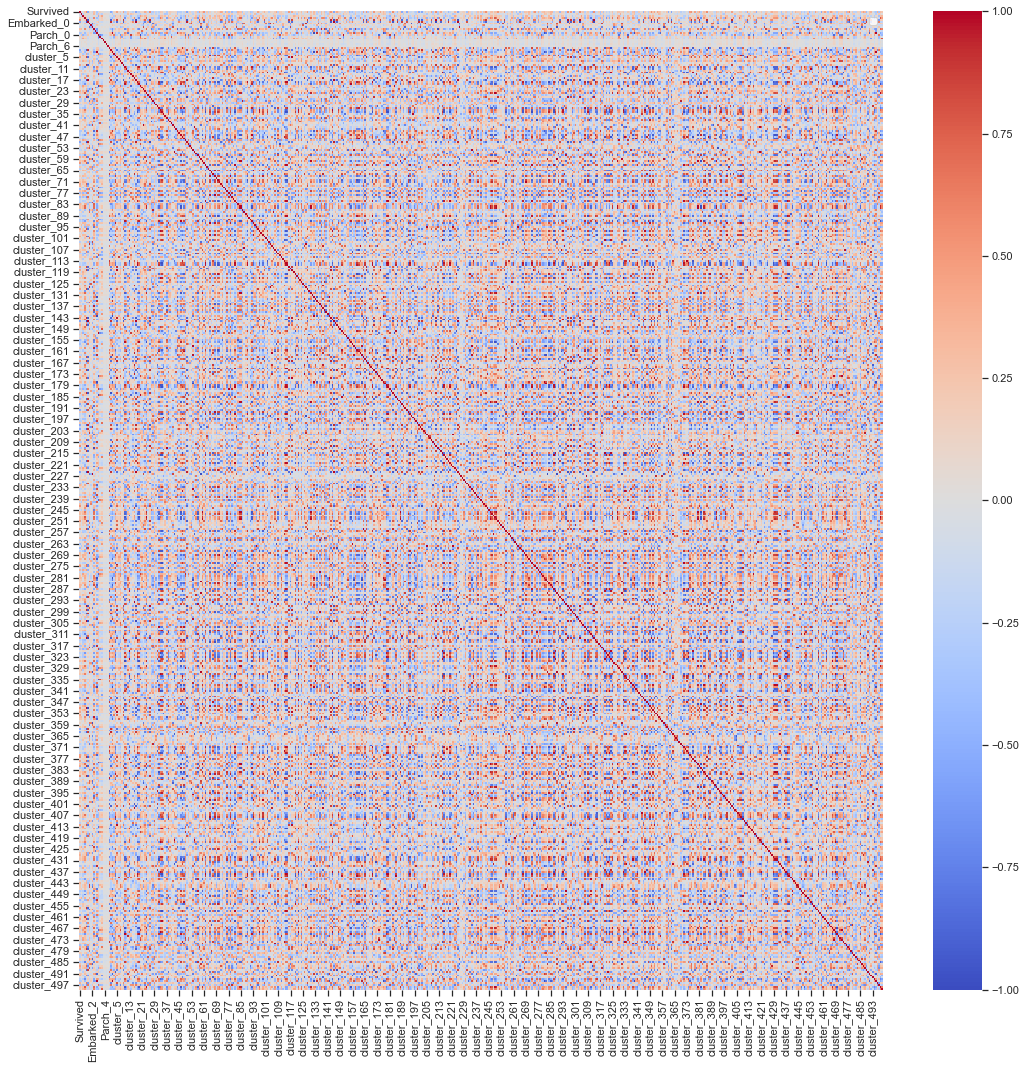

In [272]:
list_for_work = create_combined_list(preproc_train[['Fare',
                                                    'Sex_0',
                                                    'Sex_1',
                                                    'Embarked_0',
                                                    'Embarked_2',
                                                    'Pclass_1',
                                                    'Pclass_3',
                                                    'Parch_0',
                                                    'Parch_2']])
add_resul = []
for k in list_for_work:
    relust = []
    for i in np.arange(2,6,1):
            model = KMeans(n_clusters=i).fit(preproc_train[k])
            preds = model.labels_
            result_row = np.array([i,
                                   calinski_harabasz_score(preproc_train[k], preds),
                                   davies_bouldin_score(preproc_train[k], preds)
                                  ])
            relust.append(result_row)      
    clust_df = pd.DataFrame(relust, columns=['кластер', 'Калиский-Харабаср, больше лучше', 'Дэвид-Болдуин, меньше-лучше'])
    add_resul.append(relust)
    
    
cluster_list = []
for i in add_resul:
    best_clusters = find_best_ratio(pd.DataFrame(i, columns=['кластер', 'Калиский-Харабаср, больше лучше', 'Дэвид-Болдуин, меньше-лучше']))
    cluster_list.append(best_clusters)
    
    
    
dict_clust = {}
count = 0
for i in list_for_work:
    dict_clust[count] = [int(cluster_list[list_for_work.index(i)]),i]
    count+=1
    
    
def create_clusters(dict, df):
    count = 0
    for i in dict.values():
        model = KMeans(n_clusters=i[0],init = 'random',n_init='auto')
        model.fit(df[i[1]])
        df[f'cluster_{count}'] = model.labels_
        count+=1
    return df

preproc_train = preproc_train.drop([i for i in preproc_train.columns if 'cluster_' in i], axis=1)
preproc_train = create_clusters(dict_clust, preproc_train)

used_list(list_for_work)

plt.figure(figsize=(18, 18))
sns.heatmap(data=preproc_train.corr(), cmap='coolwarm')
plt.legend('right')
plt.show()
to_corr_list = {}
for i in [j for j in preproc_train.columns if 'cluster_' in j]:
    #print(f'корреляция по {i} ',preproc_train[i].corr(preproc_train['Survived'])*100)
    if preproc_train[i].corr(preproc_train['Survived'])*100 > 50 or preproc_train[i].corr(preproc_train['Survived'])*100 < -50:
        to_corr_list[court] = [list_for_work[int(i.split('_')[1])], preproc_train[i].corr(preproc_train['Survived'])*100]
        court+=1

In [229]:
preproc_train['Age'].corr(preproc_train['Survived'])

-0.06981101300650598

In [262]:
with open(r'C:\Users\aleksandrovva1\Desktop\titanic\used_pairs.txt', 'r') as file:
    lines = file.readlines()
    for i in list_for_work:
        file.write('\n'.join(map(str, i)))

UnsupportedOperation: not writable

In [259]:
for i in [3,9,29,38,49,56,59,98]:
    print(list_for_work[i])

['Parch_2', 'Sex_0', 'Embarked_0', 'Embarked_2']
['Pclass_3', 'Parch_0', 'Sex_1']
['Sex_1', 'Pclass_1', 'Sex_0', 'Parch_2', 'Parch_0']
['Sex_1', 'Pclass_3', 'Sex_0', 'Parch_0', 'Embarked_0']
['Parch_2', 'Sex_0', 'Sex_1']
['Sex_1', 'Embarked_2', 'Embarked_0']
['Parch_2', 'Sex_1']
['Sex_1', 'Parch_0', 'Sex_0', 'Embarked_0', 'Pclass_1']


In [248]:
preproc_train

,Survived,Age,SibSp,Fare,Sex_0,Sex_1,Embarked_0,Embarked_1,Embarked_2,Pclass_1,...,cluster_90,cluster_91,cluster_92,cluster_93,cluster_94,cluster_95,cluster_96,cluster_97,cluster_98,cluster_99
0,0,22.0,1,7.250,0,1,0,0,1,0,...,1,1,2,1,1,1,0,2,0,4
1,1,38.0,1,71.283,1,0,1,0,0,1,...,2,2,1,2,0,0,2,4,1,2
2,1,26.0,0,7.925,1,0,0,0,1,0,...,1,1,2,1,1,1,0,2,1,4
3,1,35.0,1,53.100,1,0,0,0,1,1,...,2,1,2,2,0,0,2,0,1,0
4,0,35.0,0,8.050,0,1,0,0,1,0,...,1,1,2,1,1,1,0,2,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,27.0,0,13.000,0,1,0,0,1,0,...,1,1,2,2,1,2,4,2,0,4
887,1,19.0,0,30.000,1,0,0,0,1,1,...,3,1,2,2,3,0,2,0,1,0
888,0,29.7,1,23.450,1,0,0,0,1,0,...,3,0,0,0,3,4,1,0,1,0
889,1,26.0,0,30.000,0,1,1,0,0,1,...,3,2,1,2,3,0,2,0,0,0


In [285]:
for i, k in to_corr_list.items():
    for j, l in dict_clust.items():
        if k[0] == l[1]:
            print('YES')

YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES


In [283]:
for i,j in to_corr_list.items():
    print(i,j)

0 [['Pclass_1', 'Parch_0', 'Sex_1', 'Sex_0'], -53.52461800663585]
1 [['Sex_1', 'Parch_2'], -54.33513806577545]
2 [['Parch_2', 'Sex_1'], 54.30040074667319]
3 [['Parch_2', 'Sex_1'], -54.30040074667319]
4 [['Sex_0', 'Parch_0', 'Sex_1', 'Pclass_3', 'Pclass_1'], 51.90746458614544]
5 [['Embarked_0', 'Sex_1', 'Embarked_2'], 50.148707184103294]
6 [['Sex_1', 'Sex_0'], -54.33513806577545]
7 [['Pclass_3', 'Parch_2', 'Sex_0', 'Pclass_1'], 51.137846609440174]
8 [['Sex_0', 'Pclass_1'], 56.24853691204139]
9 [['Parch_0', 'Sex_1'], -52.55740568141734]
10 [['Sex_1', 'Embarked_0', 'Parch_0', 'Parch_2', 'Pclass_1'], -50.963022364068635]
11 [['Parch_0', 'Sex_1', 'Embarked_0'], -54.593576600891815]
12 [['Sex_1', 'Pclass_3'], -53.28019306622623]
13 [['Pclass_1', 'Parch_0', 'Sex_0', 'Embarked_2', 'Sex_1'], 54.33513806577545]
14 [['Parch_2', 'Sex_0', 'Sex_1', 'Pclass_1', 'Parch_0'], -54.33513806577545]
15 [['Sex_0', 'Pclass_3', 'Sex_1'], 53.280193066226225]
16 [['Parch_0', 'Sex_0', 'Parch_2'], 50.7027225757461

In [279]:
to_corr_list

{0: [['Pclass_1', 'Parch_0', 'Sex_1', 'Sex_0'], -53.52461800663585],
 1: [['Sex_1', 'Parch_2'], -54.33513806577545],
 2: [['Parch_2', 'Sex_1'], 54.30040074667319],
 3: [['Parch_2', 'Sex_1'], -54.30040074667319],
 4: [['Sex_0', 'Parch_0', 'Sex_1', 'Pclass_3', 'Pclass_1'], 51.90746458614544],
 5: [['Embarked_0', 'Sex_1', 'Embarked_2'], 50.148707184103294],
 6: [['Sex_1', 'Sex_0'], -54.33513806577545],
 7: [['Pclass_3', 'Parch_2', 'Sex_0', 'Pclass_1'], 51.137846609440174],
 8: [['Sex_0', 'Pclass_1'], 56.24853691204139],
 9: [['Parch_0', 'Sex_1'], -52.55740568141734],
 10: [['Sex_1', 'Embarked_0', 'Parch_0', 'Parch_2', 'Pclass_1'],
  -50.963022364068635],
 11: [['Parch_0', 'Sex_1', 'Embarked_0'], -54.593576600891815],
 12: [['Sex_1', 'Pclass_3'], -53.28019306622623],
 13: [['Pclass_1', 'Parch_0', 'Sex_0', 'Embarked_2', 'Sex_1'],
  54.33513806577545],
 14: [['Parch_2', 'Sex_0', 'Sex_1', 'Pclass_1', 'Parch_0'],
  -54.33513806577545],
 15: [['Sex_0', 'Pclass_3', 'Sex_1'], 53.280193066226225],